In [17]:
import numpy as np 
import matplotlib.pyplot as plt 

from prml.utils.plot import plot_regression1D,plot_regression1D_with_std,plot_classifier 
from prml.utils.datasets import RegressionDataGenerator,ClassificationDataGenerator2
from prml.utils.util import sigmoid 

In [6]:
def f(x):
    return np.sin(x)

def f2(x):
    return -0.7*(x - 5/2)**2 + 3

# Gaussian Kernel

In [3]:
class GaussianKernel():
    def __init__(self,sigma=0.1):
        super(GaussianKernel,self).__init__()
        self.sigma = sigma 

    def __call__(self, x, y):
        return np.exp(-np.dot(x-y,x-y)/(2*self.sigma**2))

In [4]:
class GramMatrix():
    def __init__(self,sigma=0.1):
        self.kernel_func = GaussianKernel(sigma=sigma)
        
    def __call__(self,X):
        N = X.shape[0] 
        G = np.zeros((N,N))
        for i in range(N):
            G[i] = np.array([self.kernel_func(X[i],X[j]) for j in range(N)])
        return G

# Dual Representations 

In [5]:
class DualRegression():
    def __init__(self,lamda=0.1,sigma=0.1):
        self.kernel_func = GaussianKernel(sigma=sigma)
        self.gram_func = GramMatrix(sigma)
        self.lamda = lamda
        self.dual_weight = None 
        self.X = None 

    def fit(self,X,y):
        self.X = X 
        N = X.shape[0]
        gram_mat = self.gram_func(X) 
        self.dual_weight = np.dot(np.linalg.inv(gram_mat + self.lamda*np.eye(N)),y)

    def predict(self,X):
        gram_mat = np.zeros((self.X.shape[0],X.shape[0]))
        for i in range(self.X.shape[0]):
            gram_mat[i] = np.array([self.kernel_func(self.X[i],X[j]) for j in range(X.shape[0])])
        y = gram_mat.T@self.dual_weight
        return y

RMSE : 0.07423106783886345


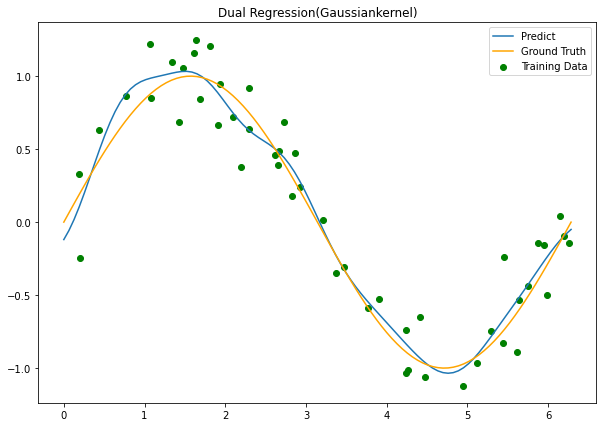

In [7]:
dual_regressor = DualRegression(lamda=1e-1,sigma=0.5) 
generator = RegressionDataGenerator(f)

X,y = generator(lower=0,upper=2*np.pi,std=0.2) 
dual_regressor.fit(X,y) 
plot_regression1D(X,y,dual_regressor,"Dual Regression(Gaussiankernel)",f)

# Nadaraya Watson Model

In [8]:
class NadarayaWatson():
    def __init__(self,g):
        self.g = g 
    
    def fit(self,X,y):
        self.X = X 
        self.y = y 

    def predict(self,X): 
        y = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            kernel = np.array([self.g(np.dot(X[i]-self.X[j],X[i]-self.X[j])**0.5) for j in range(self.X.shape[0])])
            kernel /= kernel.sum()
            y[i] = np.dot(kernel,self.y)
        
        return y.reshape(-1,1)

RMSE : 0.3382507959169169


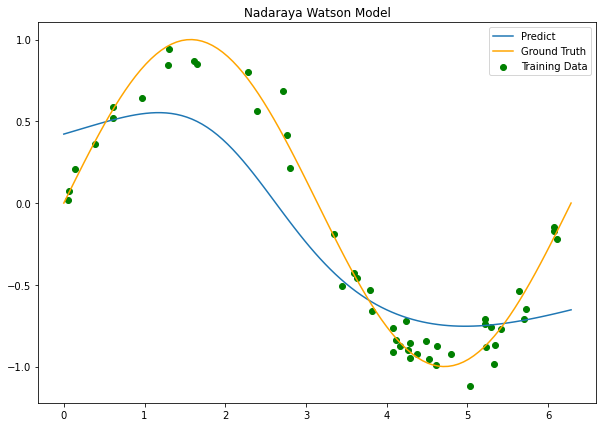

In [9]:
def g(x):
    return np.exp(-0.5*x**2)

watson = NadarayaWatson(g=g)
generator = RegressionDataGenerator(f)

X,y = generator(lower=0,upper=2*np.pi,std=0.1) 
watson.fit(X,y) 
plot_regression1D(X,y,watson,"Nadaraya Watson Model",f)

# Gaussian Process for Regression 

In [10]:
class GaussianProcessRegression():
    def __init__(self,alpha=1.0,beta=5.0,sigma=0.1):
        self.kernel_func = GaussianKernel(sigma=sigma)
        self.gram_func = GramMatrix(sigma=sigma)
        self.alpha = alpha 
        self.beta = beta 

    def fit(self,X,y):
        self.X = X 
        self.y = y 
        C = self.gram_func(X)/self.alpha + np.eye(X.shape[0])/self.beta 
        self.C_inv = np.linalg.inv(C) 

    def predict(self,X,return_std=False):
        gram_mat = np.zeros((self.X.shape[0],X.shape[0]))
        for i in range(self.X.shape[0]):
            gram_mat[i] = np.array([self.kernel_func(self.X[i],X[j]) for j in range(X.shape[0])])
        
        y = gram_mat.T@self.C_inv@self.y 
        if return_std:
            c = np.array([self.kernel_func(X[i],X[i]) for i in range(X.shape[0])]).reshape(-1,1) + 1/self.beta 
            sigma = c - np.diag(gram_mat.T@self.C_inv@gram_mat).reshape(-1,1)
            return y,sigma**0.5
        else:
            return y 

RMSE : 0.16784458136171976


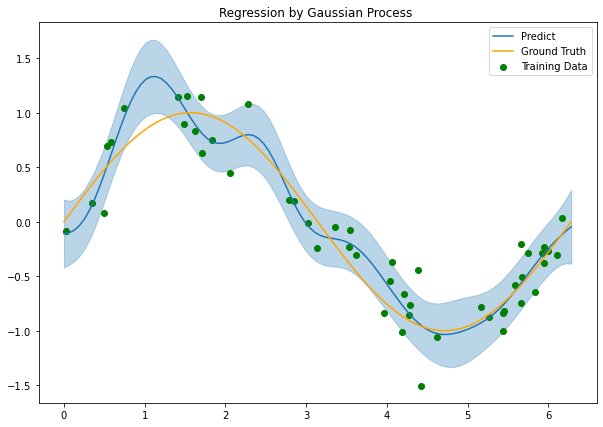

In [12]:
gp = GaussianProcessRegression(beta=20.0,sigma=0.5)

generator = RegressionDataGenerator(f)

X,y = generator(lower=0,upper=2*np.pi,std=0.2) 
gp.fit(X,y) 
plot_regression1D_with_std(X,y,gp,"Regression by Gaussian Process ",f)

# Gaussian Process for Classification 

In [14]:
class GaussianProcessClassifier():
    def __init__(self,alpha=1.0,gamma=0.1,max_iter=100,threshold=1e-2,sigma=0.1):
        self.kernel_func = GaussianKernel(sigma=sigma)
        self.gram_func = GramMatrix(sigma=sigma)
        self.alpha = alpha 
        self.gamma = gamma 
        self.max_iter = max_iter 
        self.threshold = threshold 


    def fit(self,X,y):
        y = y.reshape(-1,1) 

        self.X = X 
        self.y = y 
        C = self.gram_func(X)/self.alpha + np.eye(X.shape[0])*self.gamma  
        C_inv = np.linalg.inv(C) 

        # search mode using Neweton-method 
        a = np.random.randn(X.shape[0],1)
        for _ in range(self.max_iter):
            sig = sigmoid(a) 
            W = sig*(1 - sig)
            a = C@np.linalg.inv(np.eye(X.shape[0]) + W*C)@(y - sig + W*a) 
            da = y - sig - C_inv@a 
            if np.dot(da.ravel(),da.ravel())**0.5 < self.threshold:
                break
        
        self.C = C 
        self.a = a
        
    def predict(self,X,return_prob=False):
        gram_mat = np.zeros((self.X.shape[0],X.shape[0]))
        for i in range(self.X.shape[0]):
            gram_mat[i] = np.array([self.kernel_func(self.X[i],X[j]) for j in range(X.shape[0])]) 

        sig = sigmoid(self.a)
        logit = (gram_mat.T@(self.y - sig)).ravel()
        sig = sig.ravel()

        if return_prob:
            c = np.array([self.kernel_func(X[i],X[i]) for i in range(X.shape[0])]) + self.gamma
            W = np.diag(1/(sig*(1 - sig))) 
            sigma = c - np.diag(gram_mat.T@np.linalg.inv(W + self.C)@gram_mat)
            prob = sigmoid(kappa(sigma)*logit) 
            return prob  
        else: 
            y = np.zeros(X.shape[0])
            y[logit >= 0] = 1
            return y 

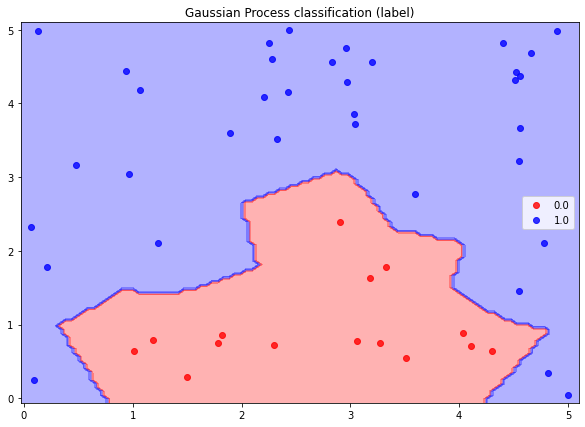

In [18]:
gen = ClassificationDataGenerator2(f2) 
X_tr,y_tr = gen(encoding="label")  

gpc = GaussianProcessClassifier(max_iter=10,alpha=1e-3,gamma=1e-4)
gpc.fit(X_tr,y_tr)
plot_classifier(X_tr,y_tr,gpc,title="Gaussian Process classification (label)")